/tmp/ipykernel_47/3429897689.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
/tmp/ipykernel_47/3429897689.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

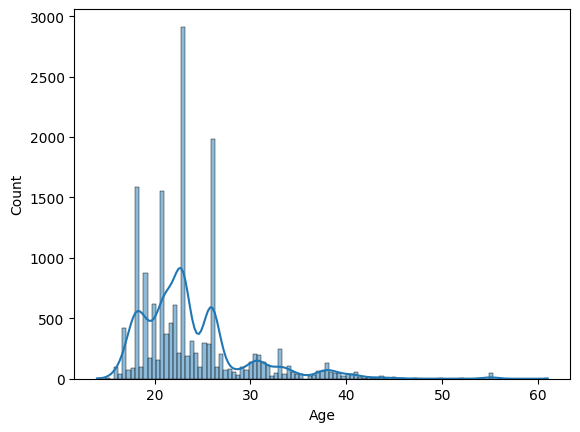

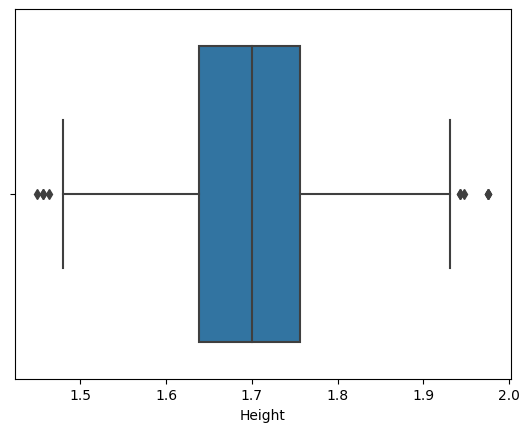

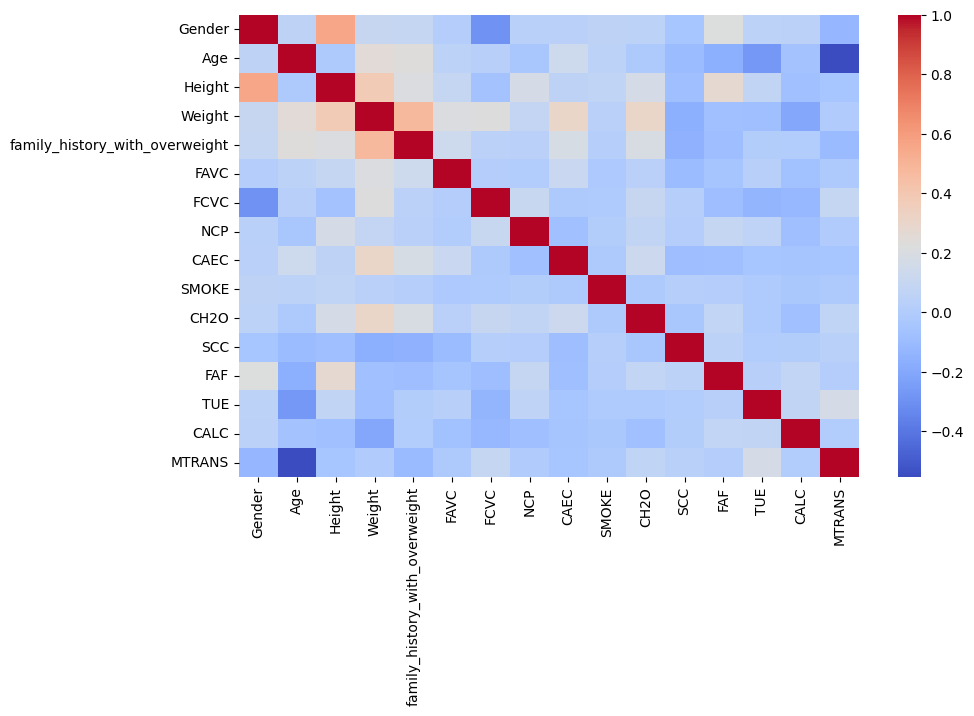

Accuracy: 0.8567128236002408
[[326  36   7   0   1   3   4]
 [ 31 379   5   0   1  34  18]
 [  0   3 387  18   3  17  41]
 [  0   0  17 492   3   1  14]
 [  0   0   1   2 688   0   0]
 [  2  51  18   2   2 264  49]
 [  0  18  32   9   0  33 310]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       377
           1       0.78      0.81      0.79       468
           2       0.83      0.83      0.83       469
           3       0.94      0.93      0.94       527
           4       0.99      1.00      0.99       691
           5       0.75      0.68      0.71       388
           6       0.71      0.77      0.74       402

    accuracy                           0.86      3322
   macro avg       0.84      0.84      0.84      3322
weighted avg       0.86      0.86      0.86      3322

Submission file created successfully!


In [7]:
# -------------------------------------------------------
# IMPORTS
# -------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# -------------------------------------------------------
# 2. LOAD DATA
# -------------------------------------------------------
train = pd.read_csv('/kaggle/input/ai-201-b-mse-2-aiml-b/train.csv')
test = pd.read_csv('/kaggle/input/ai-201-b-mse-2-aiml-b/test.csv')



# -------------------------------------------------------
# 3. BASIC CLEANING
# -------------------------------------------------------
train.drop_duplicates(inplace=True)

# Fill missing values
for col in train.columns:
    if train[col].dtype == "object":
        train[col].fillna(train[col].mode()[0], inplace=True)
    else:
        train[col].fillna(train[col].median(), inplace=True)

for col in test.columns:
    if test[col].dtype == "object":
        test[col].fillna(test[col].mode()[0], inplace=True)
    else:
        test[col].fillna(test[col].median(), inplace=True)



# -------------------------------------------------------
# 4. DATA VISUALIZATION (EXAMPLES)
# -------------------------------------------------------
sns.histplot(train['Age'], kde=True)
plt.show()

sns.boxplot(x=train['Height'])
plt.show()



# -------------------------------------------------------
# 5. ENCODING
# -------------------------------------------------------
le_target = LabelEncoder()     # for target only
le = LabelEncoder()            # for features

# Encode categorical features
for col in train.select_dtypes(include="object").columns:
    if col != "NObeyesdad":
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])

# Encode target separately
train['NObeyesdad'] = le_target.fit_transform(train['NObeyesdad'])



# -------------------------------------------------------
# 6. FEATURE SCALING
# -------------------------------------------------------
scaler = StandardScaler()
numeric_cols = train.select_dtypes(include=['float64','int64']).columns.drop('NObeyesdad')

train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])



# -------------------------------------------------------
# 7. CORRELATION
# -------------------------------------------------------
plt.figure(figsize=(10,6))
sns.heatmap(train[numeric_cols].corr(), cmap='coolwarm')
plt.show()



# -------------------------------------------------------
# 8. TRAIN-TEST SPLIT
# -------------------------------------------------------
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)



# -------------------------------------------------------
# 9. RANDOM FOREST (BASE MODEL)
# -------------------------------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)



# -------------------------------------------------------
# 10. MODEL EVALUATION
# -------------------------------------------------------
y_pred = rf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))



# -------------------------------------------------------
# 11. HYPERPARAMETER TUNING
# -------------------------------------------------------
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rs = RandomizedSearchCV(
    rf,
    param_distributions=params,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)
best_model = rs.best_estimator_



# -------------------------------------------------------
# 12. FIX TEST SET BEFORE PREDICTION
# -------------------------------------------------------
# Ensure test has same features as X
cols_to_drop = [col for col in test.columns if col not in X.columns]
test_fixed = test.drop(cols_to_drop, axis=1)



# -------------------------------------------------------
# 13. PREDICT + REVERSE ENCODING
# -------------------------------------------------------
test_pred = best_model.predict(test_fixed)

# Convert encoded numbers back to actual obesity labels
test_pred_original = le_target.inverse_transform(test_pred)



# -------------------------------------------------------
# 14. CREATE SUBMISSION FILE
# -------------------------------------------------------
submission = pd.DataFrame({
    "id": test["id"],            # match Kaggle format
    "NObeyesdad": test_pred_original
})

submission.to_csv("submission.csv", index=False)
print("Submission file created successfully!")
